In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config import *
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Arial'

In [2]:
def plot_raincloud(data_path, output_name, xlabel, text_x_pos, text_offset_seasons=None, km_convert=False, city_col='city'):
    if text_offset_seasons is None:
        text_offset_seasons = []
    
    df = pd.read_csv(data_path)
    
    if km_convert:
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
        for col in numeric_cols:
            if col not in [city_col, 'city_abbr']:
                df[col] = df[col] * 1.60934
    
    seasons = [s for s in season_map.keys() if s != 'fa19']
    season_violin_colors = dict(zip(season_order, violin_colors[:len(season_order)]))
    season_box_colors = dict(zip(season_order, box_colors[:len(season_order)]))
    
    melted_df = df.melt(id_vars=[city_col], value_vars=seasons, var_name="Season", value_name="Change")
    melted_df["Season"] = melted_df["Season"].map(season_map)
    
    fig, ax = plt.subplots(figsize=(8.5, 5.5), dpi=300)
    
    # violin
    ax = sns.violinplot(y="Season", x="Change", data=melted_df, palette=season_violin_colors,
                       scale="width", inner=None, linewidth=1, order=season_order)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    for c in ax.collections:
        c.set_edgecolor("#323333")
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for violin in ax.collections: # clip violin, show upper
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))
    
    # box
    box_props = {'zorder': 10, 'edgecolor': '#323333', 'linewidth': 1.0}
    whisker_props = {'linewidth': 1.5, 'color': '#323333', 'zorder': 10}
    cap_props = {'linewidth': 1.5, 'color': '#323333', 'zorder': 10}
    median_props = {'linewidth': 2, 'color': '#323333', 'zorder': 11}
    palette = [season_box_colors[s] for s in season_order]
    
    sns.boxplot(y="Season", x="Change", data=melted_df, width=0.15, showcaps=True, showfliers=False,
               ax=ax, boxprops=box_props, whiskerprops=whisker_props, medianprops=median_props,
               capprops=cap_props, palette=palette, order=season_order)
    
    # scatter
    old_len_collections = len(ax.collections)
    for city in melted_df[city_col].unique():
        city_data = melted_df[melted_df[city_col] == city]
        ax.scatter(city_data["Change"], city_data["Season"], color=acr_color[city],
                  marker=acr_marker[city], edgecolors='none', alpha=0.7, s=95, zorder=5)
    
    y_offset = 0.2
    for i, dots in enumerate(ax.collections[old_len_collections:]):
        dots.set_offsets(dots.get_offsets() + np.array([0, y_offset]))
    
    plt.axvline(x=0, color="#323333", linestyle="--", linewidth=1, zorder=1, alpha=0.8)
    ax.invert_yaxis()
    
    plt.xlabel(xlabel, fontsize=20.5)
    plt.ylabel("Season", fontsize=22)
    ax.xaxis.labelpad = 8
    ax.yaxis.labelpad = 8
    ax.tick_params(axis='both', labelsize=20.5, pad=8)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    std_values = melted_df.groupby("Season")["Change"].std()
    label_positions = dict(zip([tick.get_text() for tick in ax.get_yticklabels()], ax.get_yticks()))
    
    for season_name in season_order:
        if season_name in label_positions and season_name in std_values:
            y_loc = label_positions[season_name]
            offset = -0.25 if season_name in text_offset_seasons else -0.1
            std_val = std_values[season_name]
            ax.text(text_x_pos, y_loc + offset, f"σ = {std_val:.2f}", va='center', ha='left', fontsize=14.5)
    
    plt.tight_layout()
    plt.show()


def plot_baseline(data_path, output_name, xlabel, xlim, xticks, convert_factor=None, minor_locator=0.5, city_col='city'):
    df = pd.read_csv(data_path)
    fig, ax = plt.subplots(figsize=(8.5, 1.2), dpi=300)
    
    for city in acr_list:
        if city in df[city_col].values and 'fa19' in df.columns:
            value = df[df[city_col] == city]['fa19'].values[0]
            if convert_factor:
                value = value * convert_factor
            ax.scatter(value, 0.5, color=acr_color[city], marker=acr_marker[city],
                      edgecolors='none', s=95, zorder=5, alpha=0.7)
    
    for spine in ax.spines.values():
        spine.set_visible(True)
    
    ax.set_xlim(xlim)
    ax.set_xticks(xticks)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.5])
    ax.set_yticklabels(['F19'])
    ax.xaxis.set_minor_locator(plt.MultipleLocator(minor_locator))
    
    ax.tick_params(which='major', direction='in', length=6, width=1.2,
                   top=True, right=True, bottom=True, left=True)
    ax.tick_params(which='minor', direction='in', length=3, width=0.8,
                   top=True, right=True, bottom=True, left=True)
    ax.tick_params(axis='y', top=False, right=False, bottom=False, left=False, pad=15)
    ax.tick_params(axis='both', which='major', labelsize=22)
    ax.set_xlabel(xlabel, fontsize=23.5, labelpad=5)
    
    plt.tight_layout(pad=0.1)
    plt.show()

### fig2a

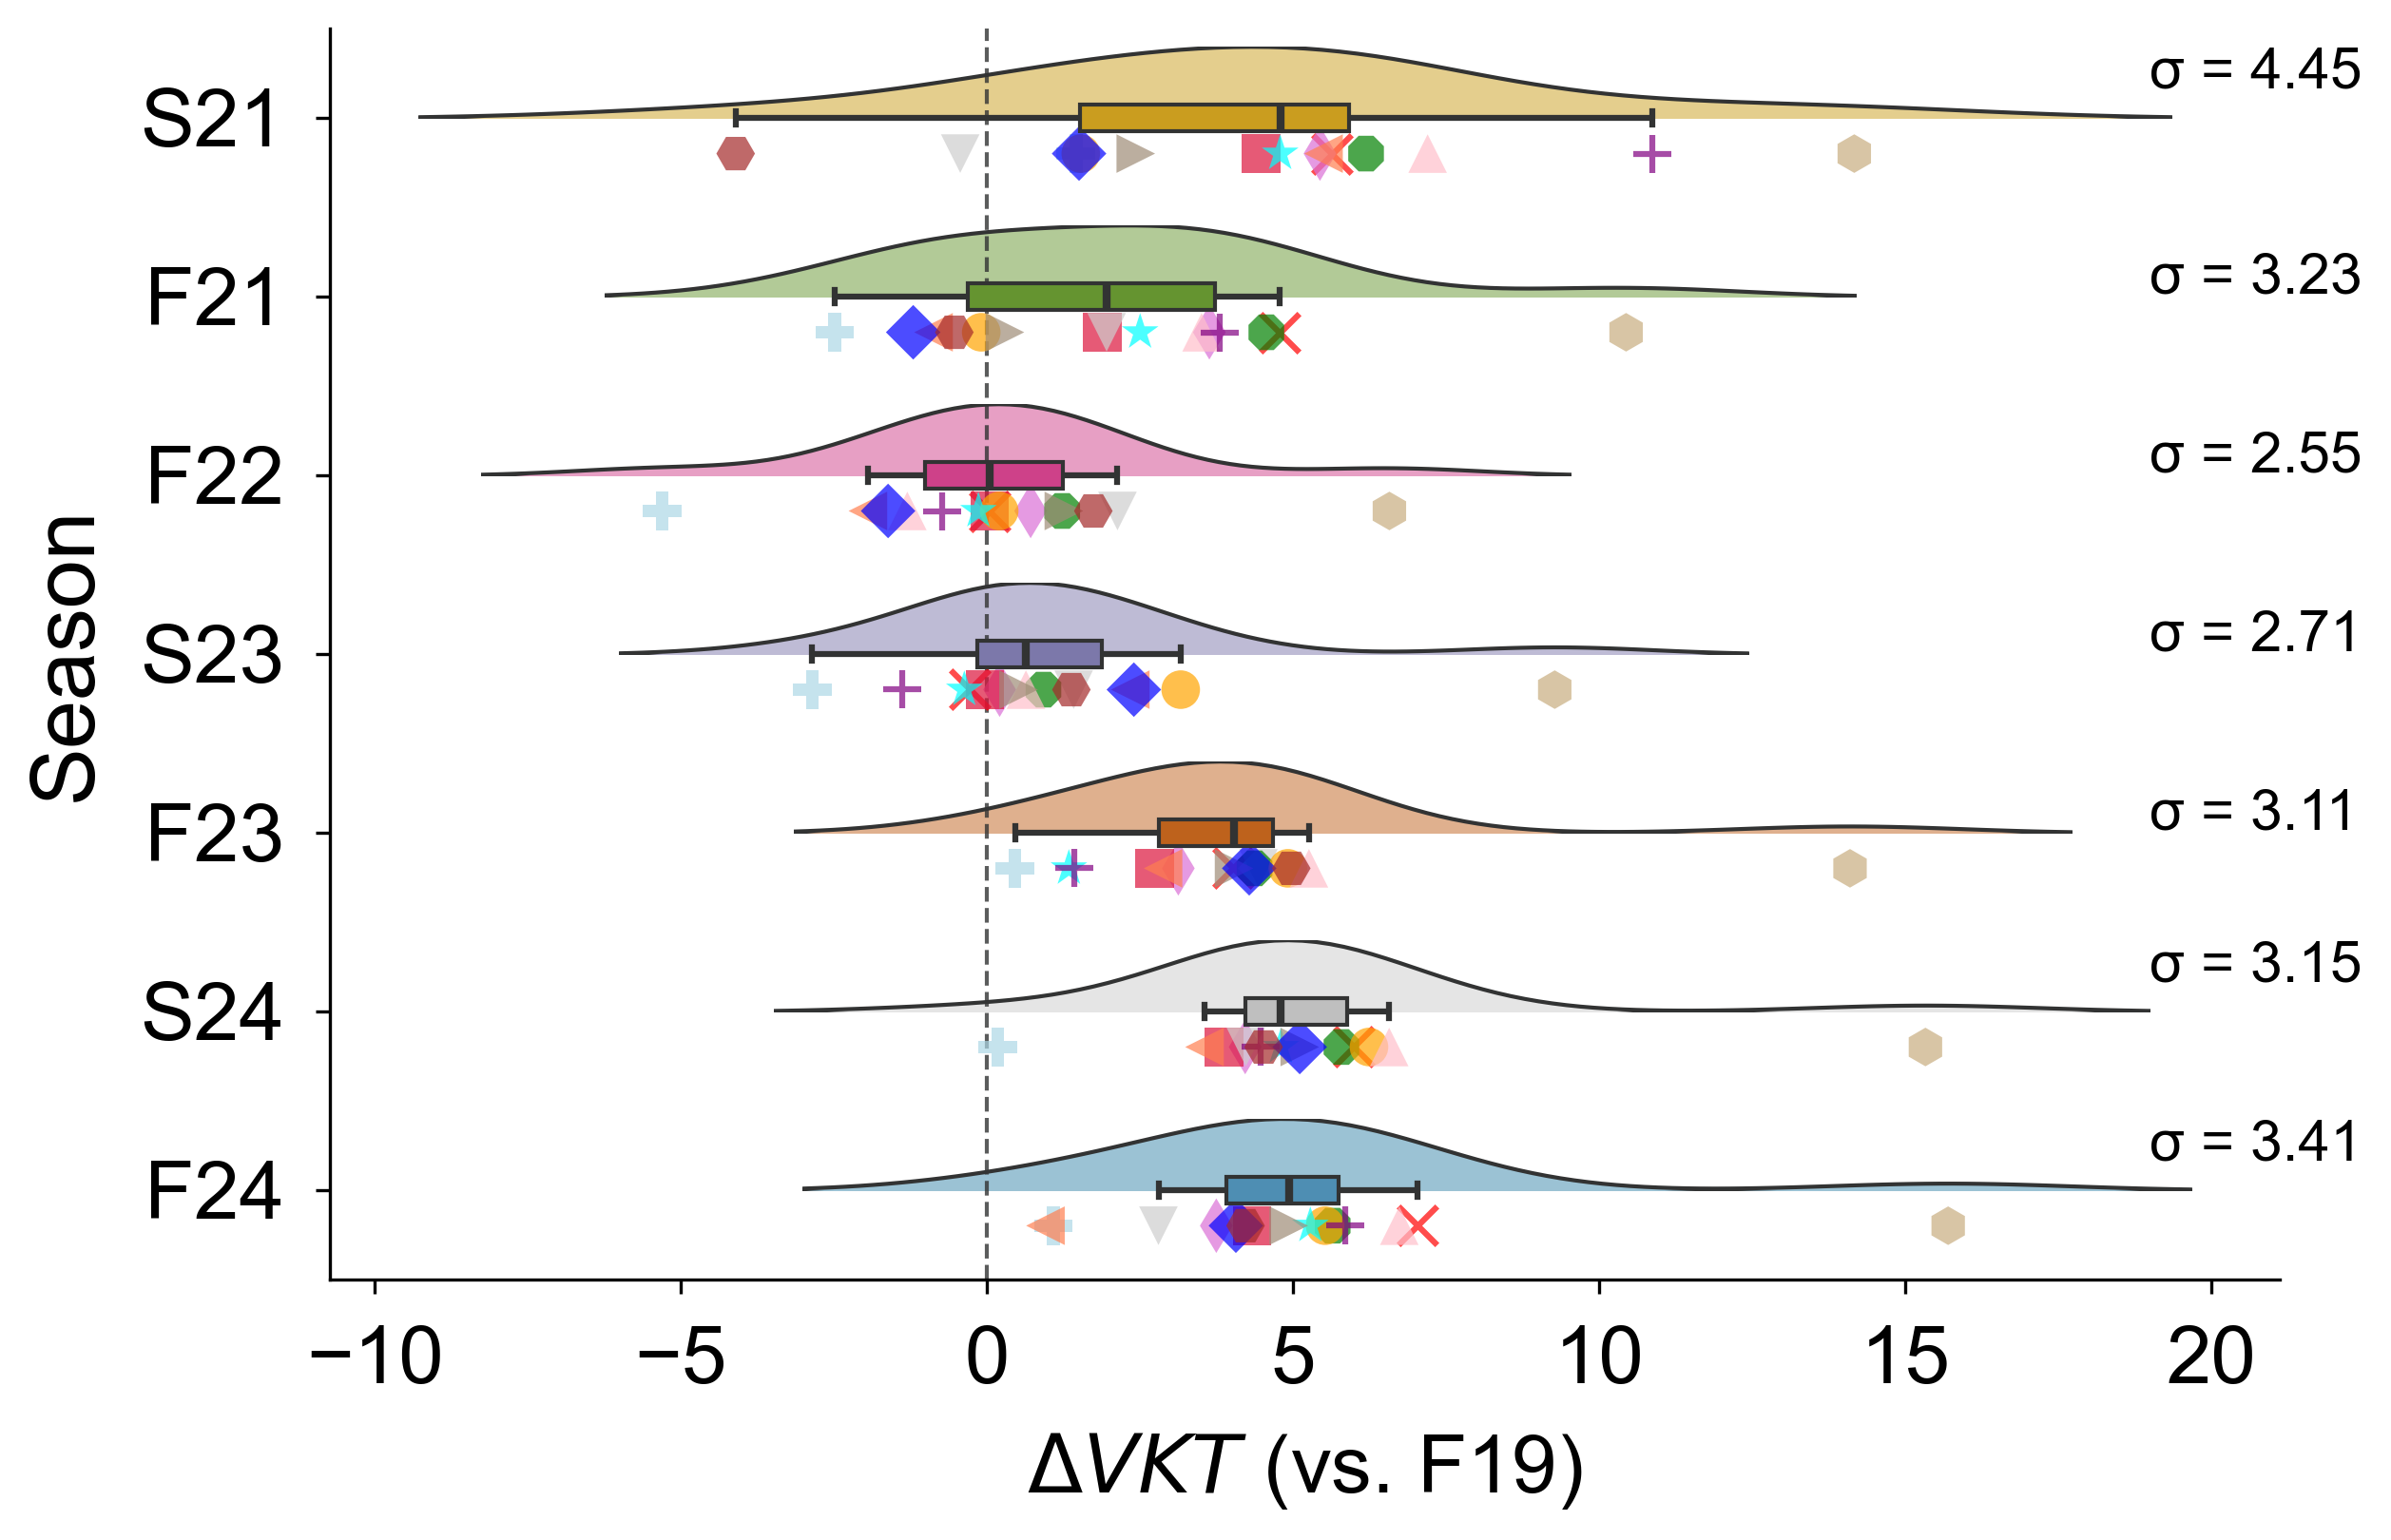

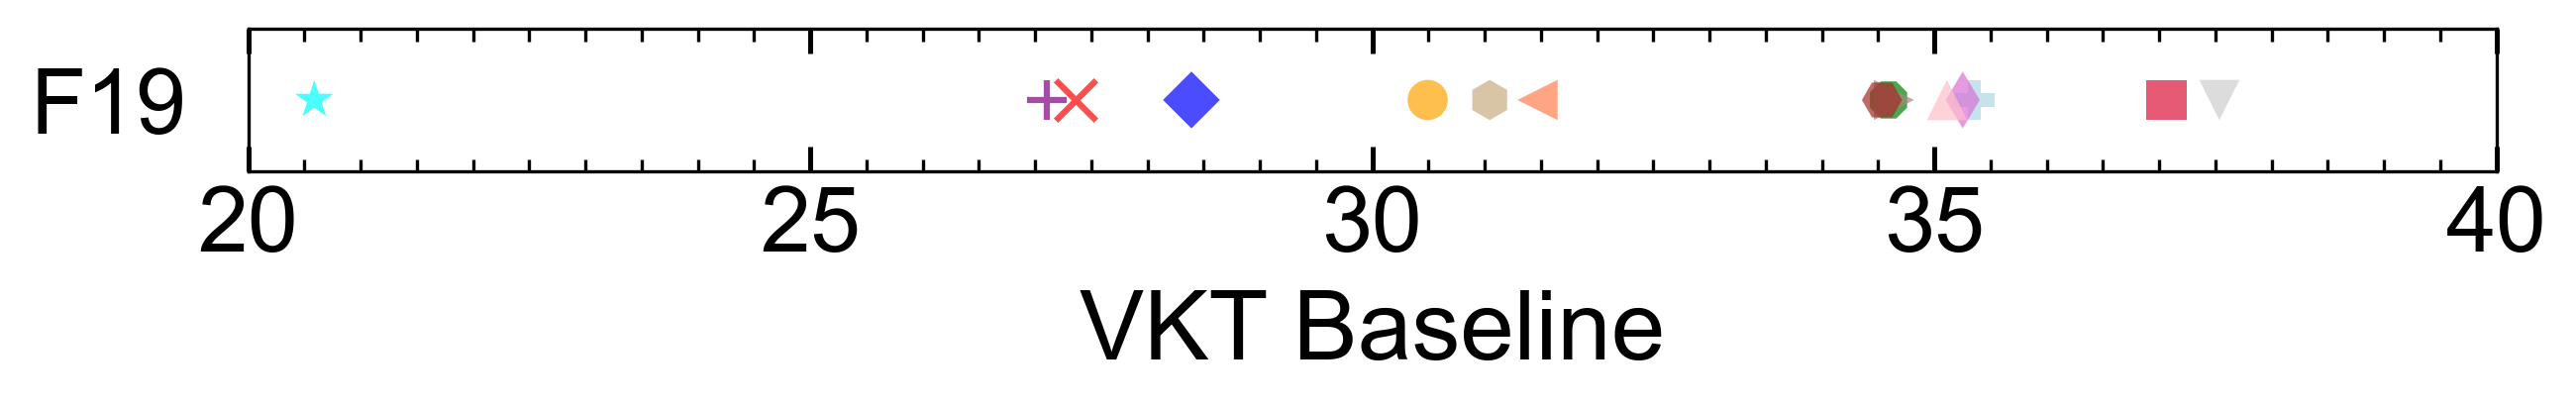

In [3]:
plot_raincloud('data/fig2/vmtc.csv', 'fig2ar', r"$\Delta VKT$ (vs. F19)", 19, ['S21','S24','F24'], km_convert=True)
plot_baseline('data/fig2/vmtb.csv', 'fig2ab', r'VKT Baseline', (20, 40), [20, 25, 30, 35, 40], convert_factor=1.60934)

### fig2b

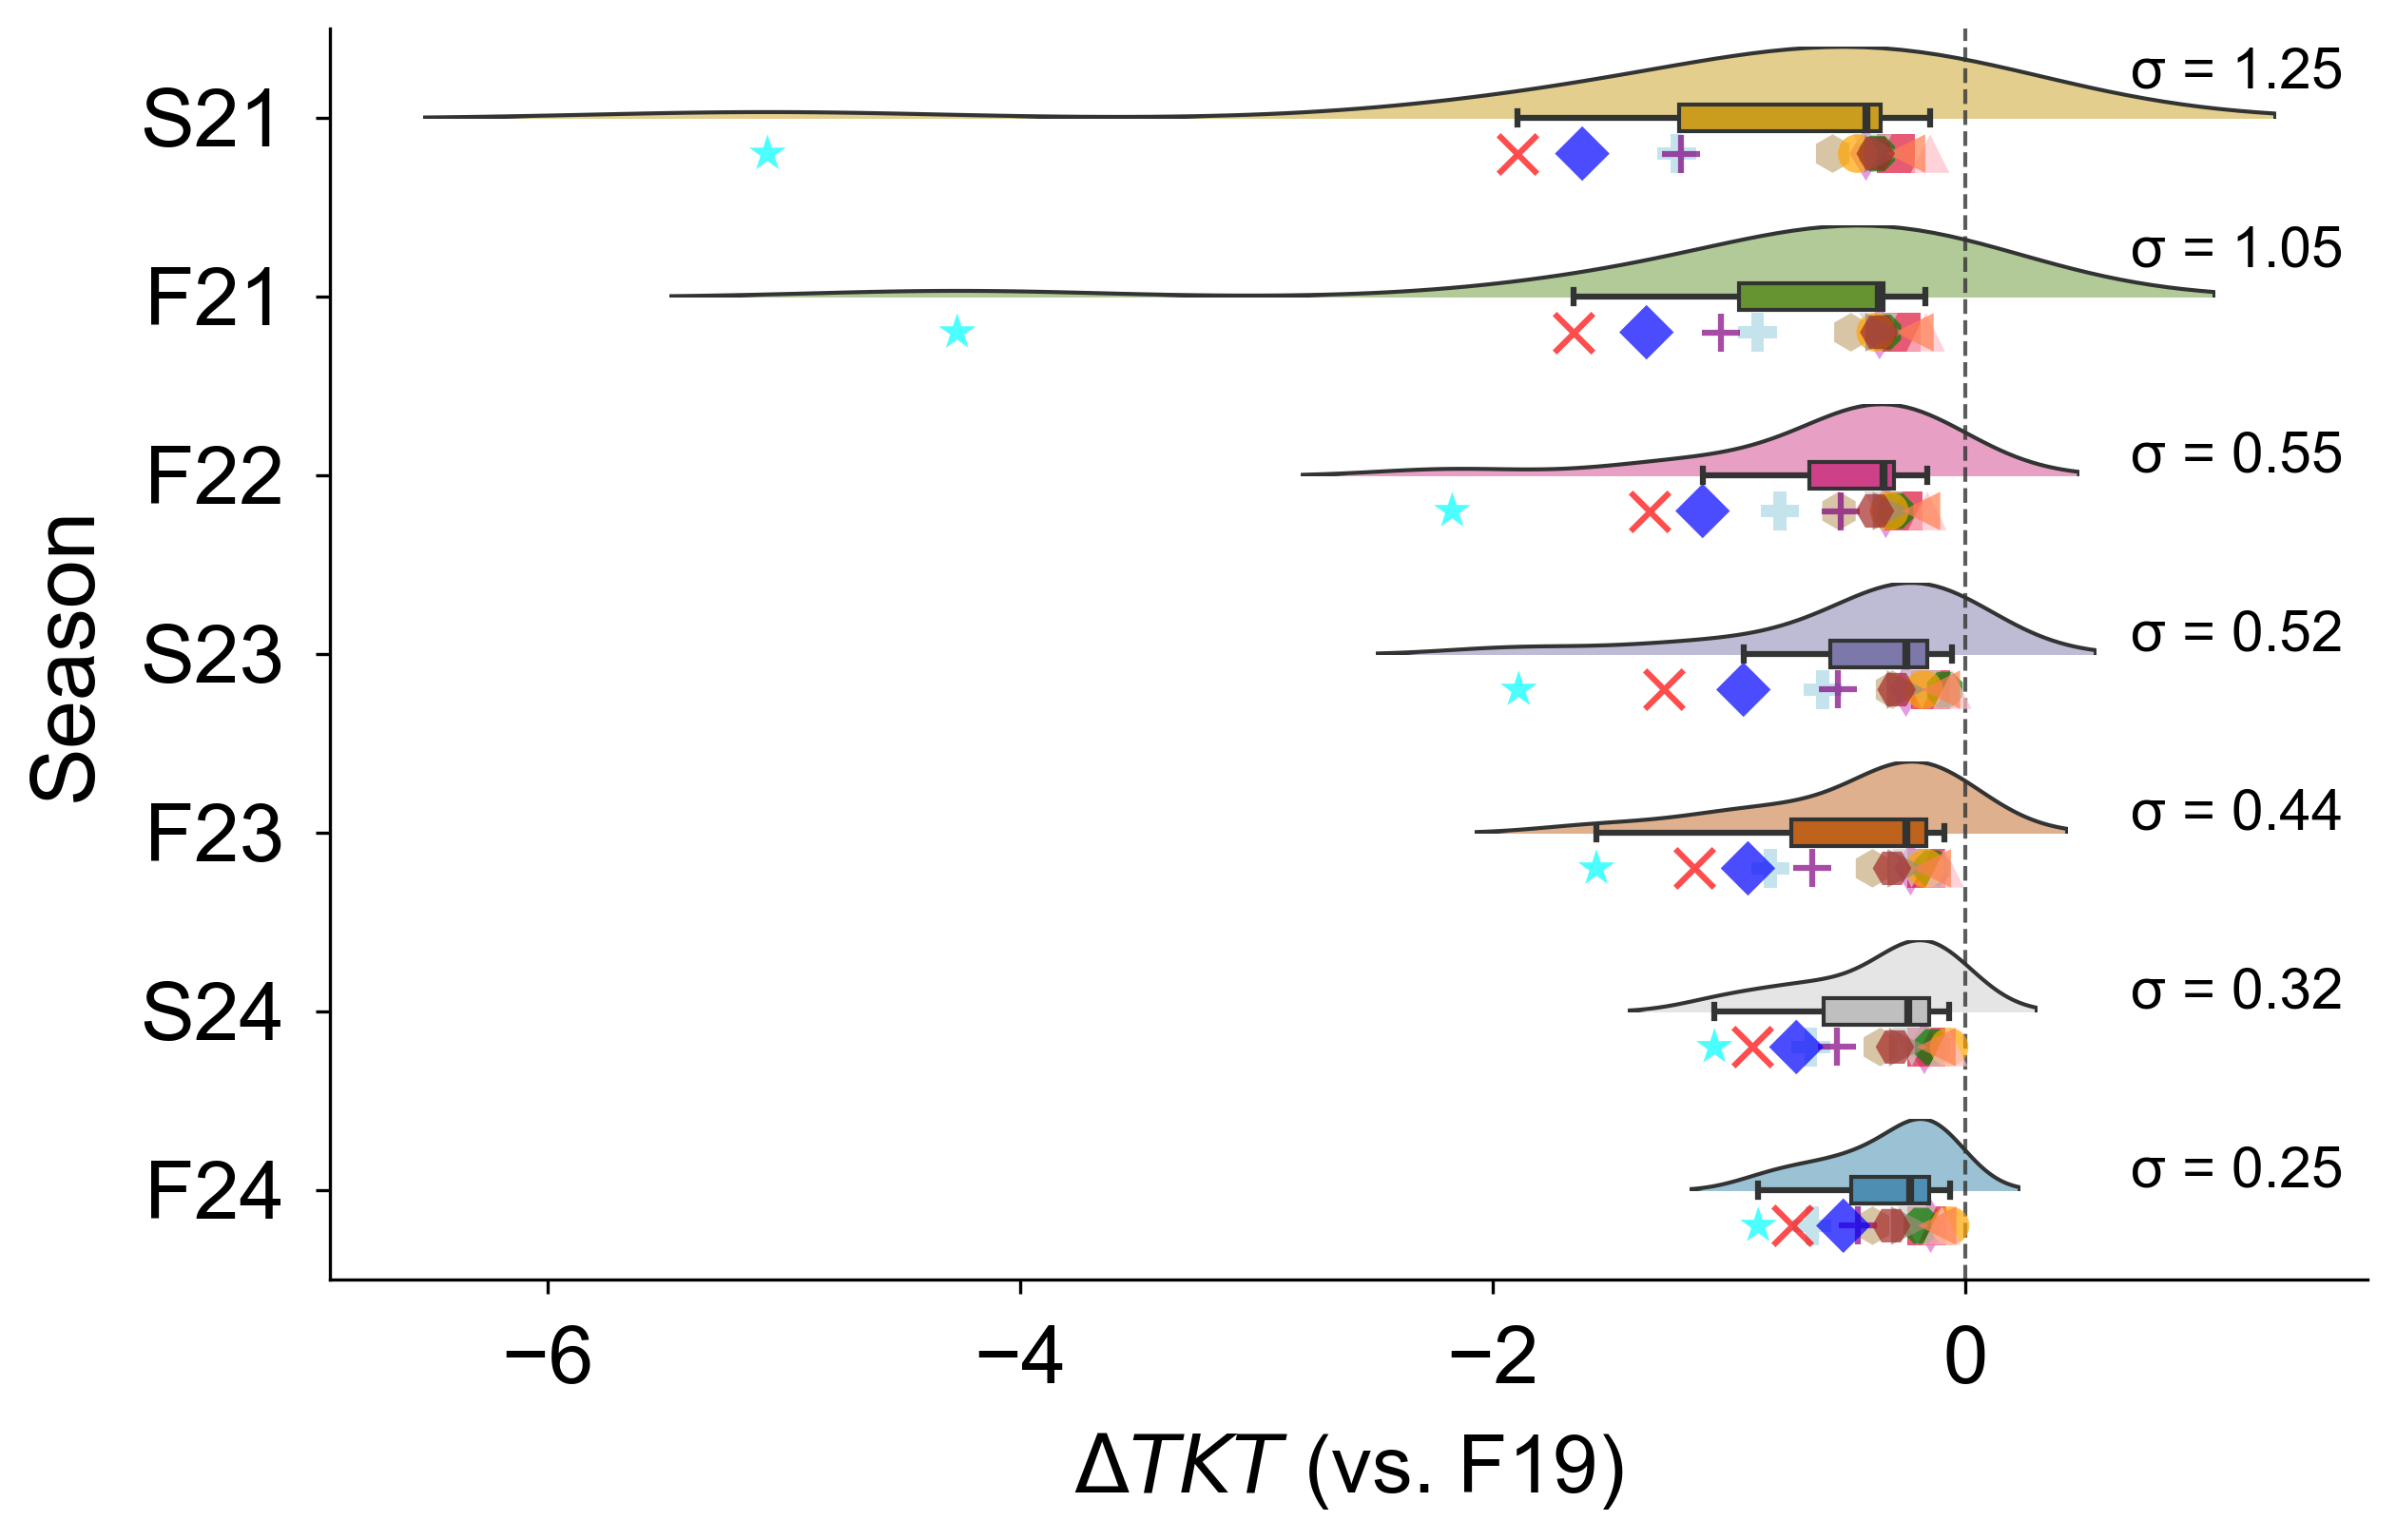

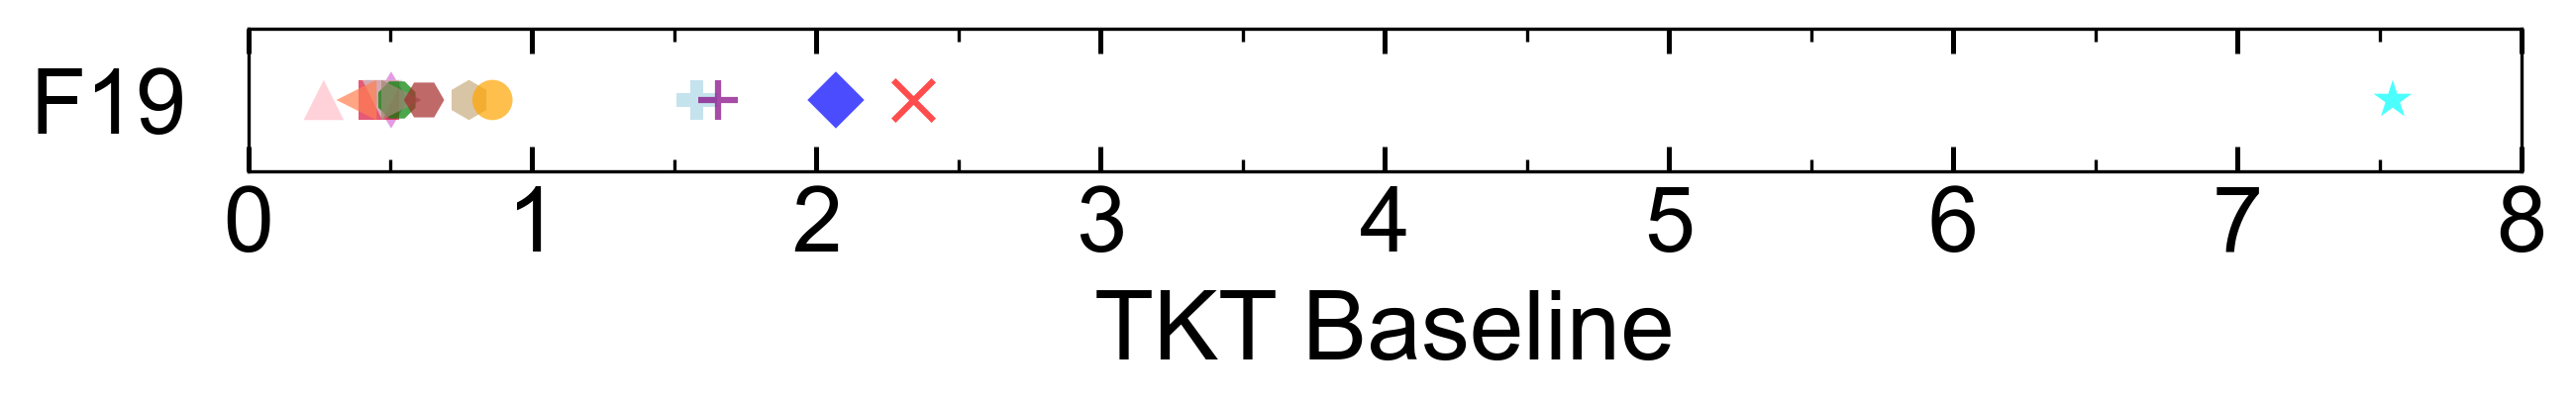

In [4]:
plot_raincloud('data/fig2/tmtc.csv', 'fig2br', r"$\Delta TKT$ (vs. F19)", 0.7, ['S21','F21'], km_convert=True)
plot_baseline('data/fig2/tmtb.csv', 'fig2bb', r'TKT Baseline', (0, 8), [0, 1, 2, 3, 4, 5, 6, 7, 8], convert_factor=1/0.621371)

### fig2c

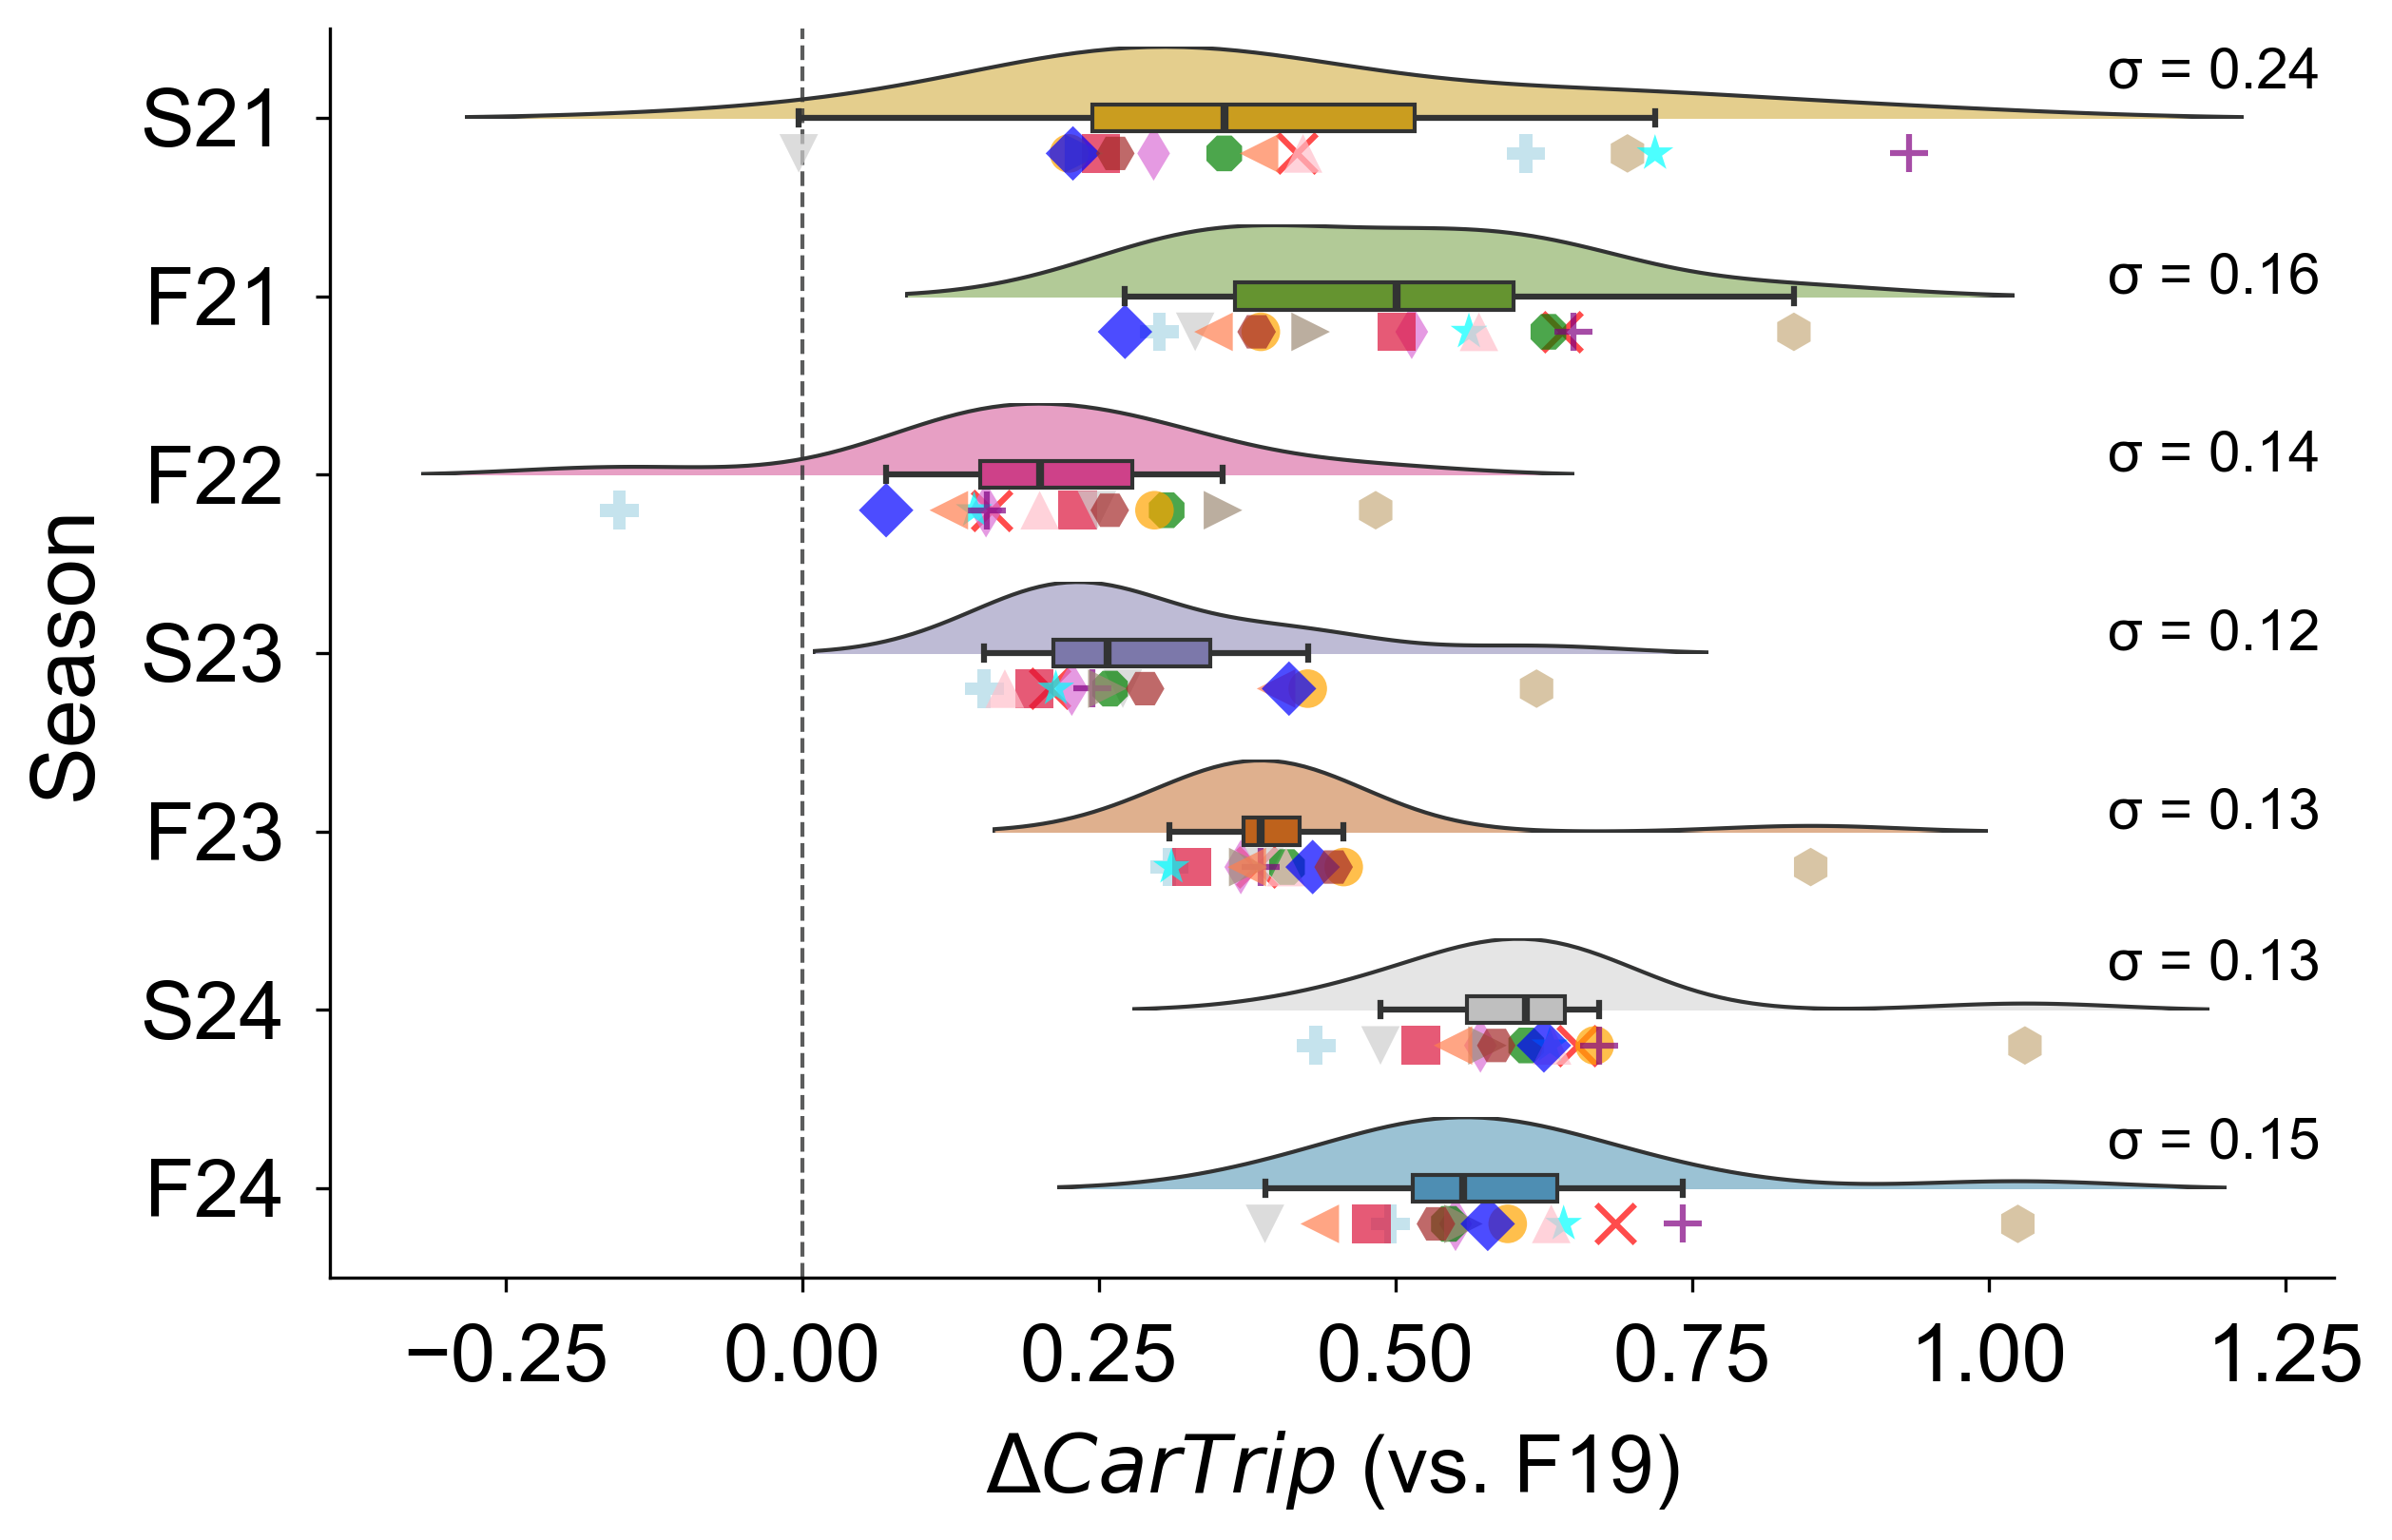

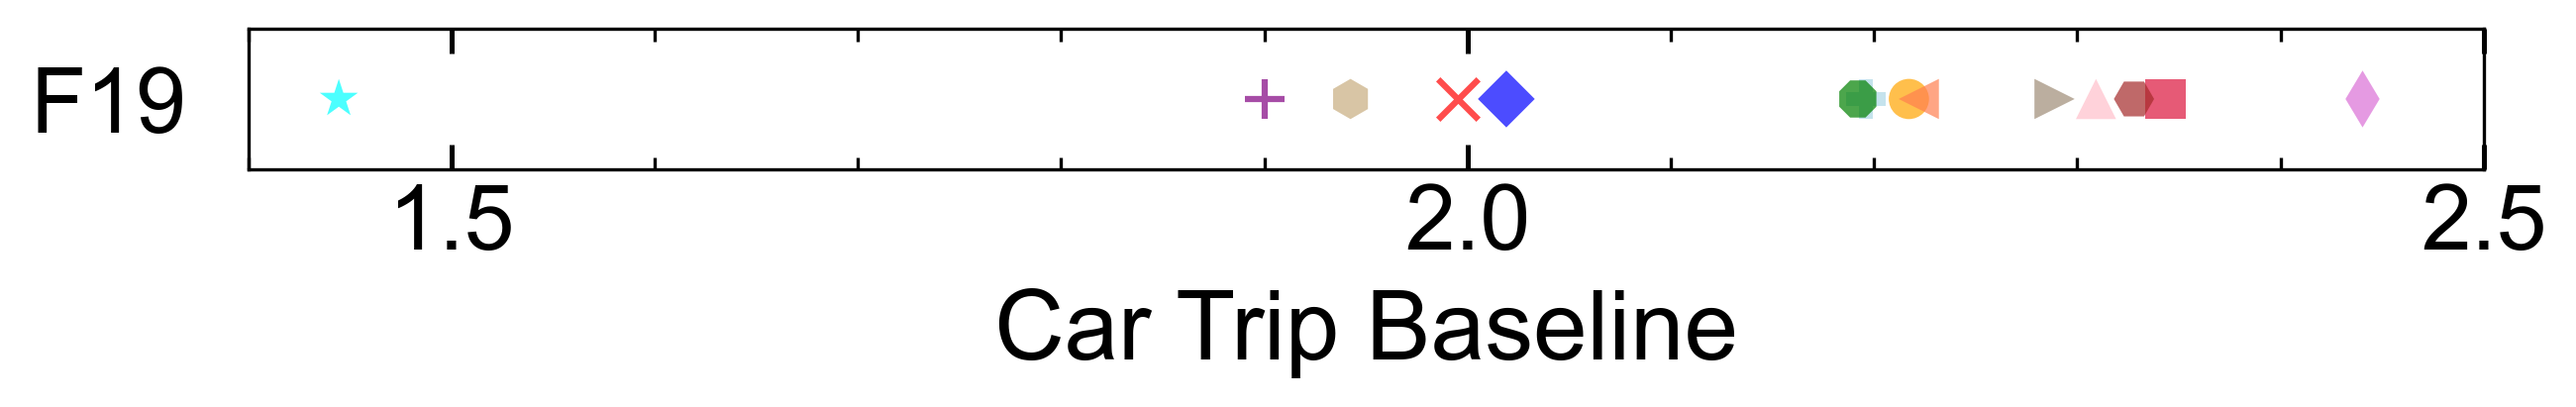

In [5]:
plot_raincloud('data/fig2/tripc.csv', 'fig2cr', r"$\Delta Car Trip$ (vs. F19)", 1.1, ['S21','S24','F24'])
plot_baseline('data/fig2/tripb.csv', 'fig2cb', 'Car Trip Baseline', (1.4, 2.5), [1.5, 2, 2.5], minor_locator=0.1)

### fig2d

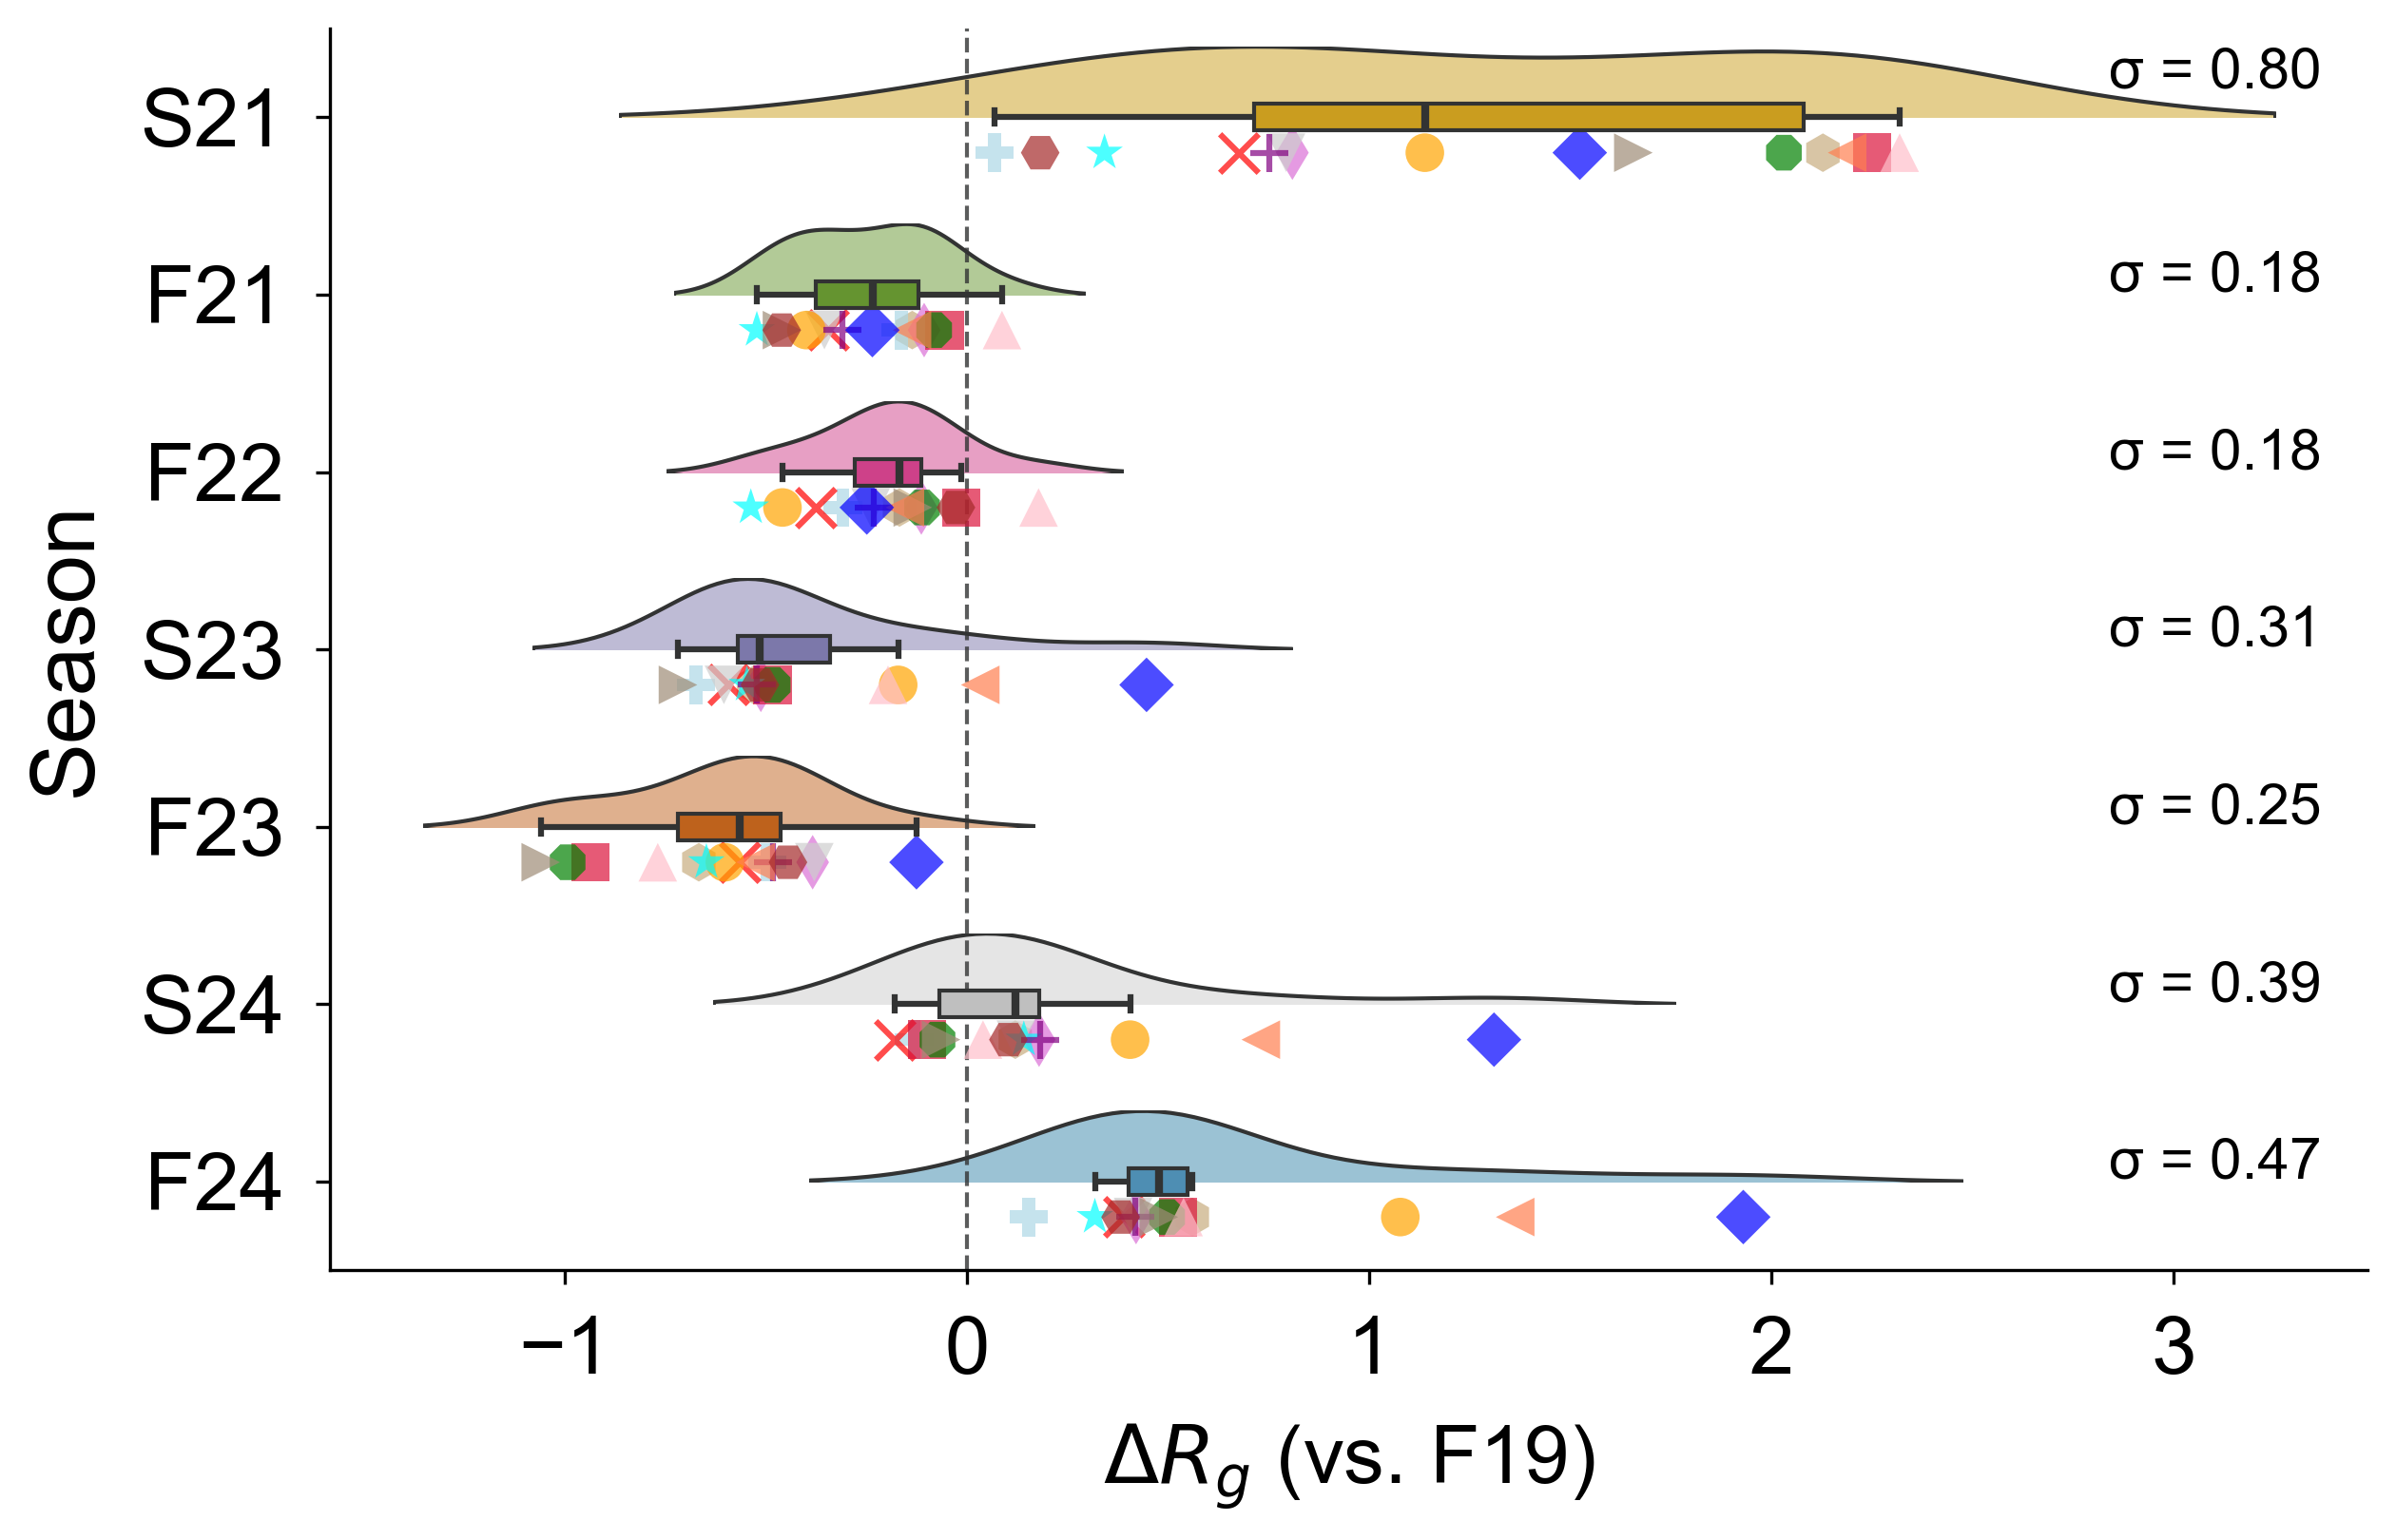

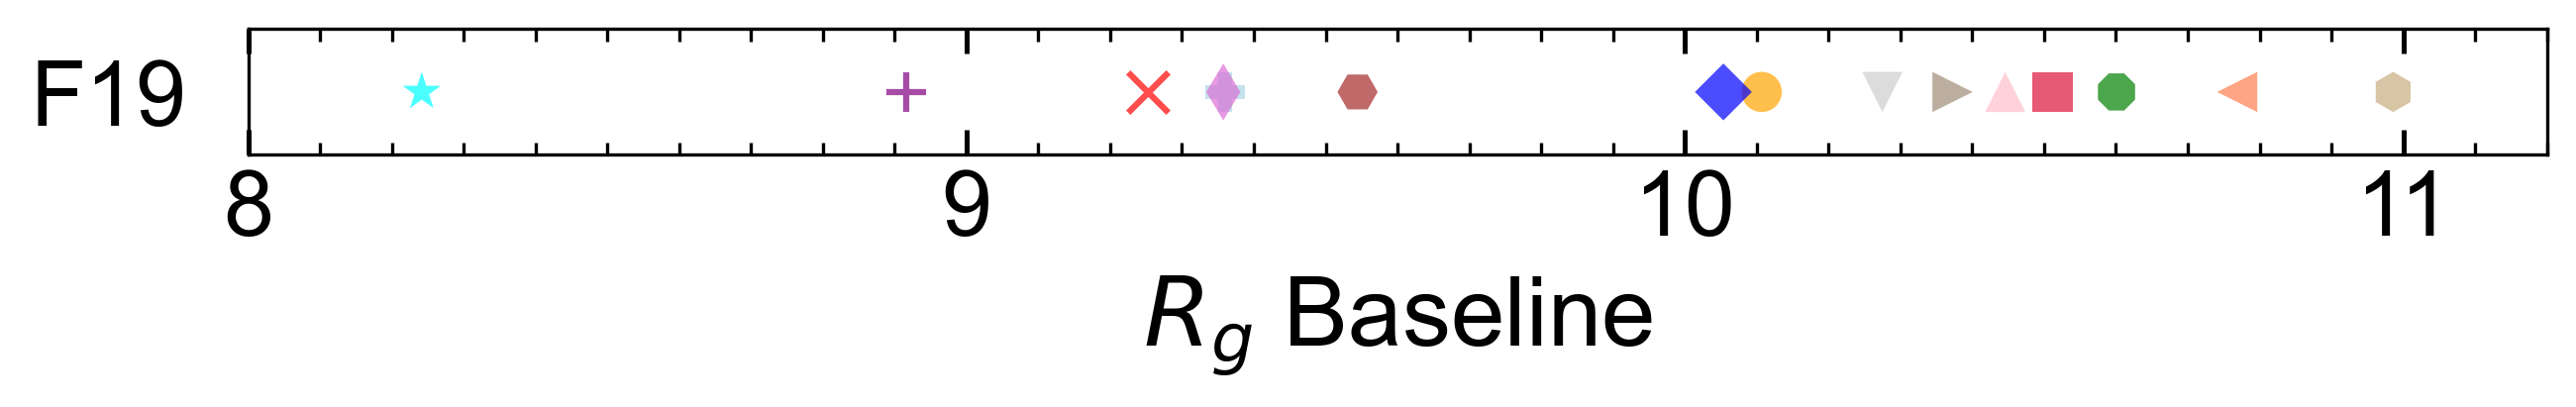

In [6]:
plot_raincloud('data/fig2/rgc.csv', 'fig2dr', r"$\Delta R_g$ (vs. F19)", 2.84, ['S21'], city_col='city_abbr')
plot_baseline('data/fig2/rgb.csv', 'fig2db', r'$R_g$ Baseline', (8, 11.2), [8, 9, 10, 11], minor_locator=0.1, city_col='city_abbr')